## DBQuery 0818_1

### to version = version="memo_0818_3"

In [27]:
### configuration
next_round = 1186
to_version="memo_0818_5"

title = "Metrics"
row_length = 400
new_to_old = True
show_mark_down = True
markdown_table_limit_length = 5
next_nums = [17, 6, 32, 28, 29, 22]

In [28]:
## this code was run.
#!pip install keras-tuner
# import numpy as np
# import pandas as pd
import os
from datetime import datetime
from tqdm import tqdm
# print(f'Current Step #01 [now = {datetime.now()}')
from IPython.display import Markdown

from lib.analy_util import ( draw_markdown,
                             draw_graph,
                             draw_scatter,
                             get_pre_bef,
                             draw_average,
                             get_frequency,
                             get_information,
                             analyze_v1,
                             data_prepare,
                             search_model,
                             get_information_v2,
                             get_extdatas,
                             )
print(f'define this code. [{datetime.now()}]')


define this code. [2025-08-18 18:48:52.734354]


In [44]:
def draw_frequency(row_nums=[], next_nums=[0]):
    """ draw_frequency """
    sel_query_0 = 'select '
    sel_query_2 = ' from results_order order by round asc;'
    sel_query_1 = []
    if len(row_nums) != len(next_nums):
        print("error : row_nums와 next_nums의 크기가 다릅니다.")
        return 
    for row_num in row_nums:
        sel_query_1.append(f'n{row_num}')
    sel_query = sel_query_0 + ", ".join(sel_query_1) + sel_query_2
    rows = !echo "{sel_query}"|sqlite3 ../db/metrics.db
    # print(rows)
    latest_nums = rows[-1]
    results = []
    for i in range(len(row_nums)):
        results.append([])
    for row in rows:
        cols = row.split("|")
        for i in range(len(cols)):
            results[i].append(int(cols[i]))
        # results.append([int(i) for i in row[0]])
    for result in results:
        print(result)
    for i in range(len(results)):
        results[i].append(next_nums[i])
        
    results += next_nums
    ext_datas = []
    show_cols = []
    
    for i in range(len(row_nums)):
        show_cols.append(i)
    
    print(f'show_cols = {show_cols}')
    
    show_label = True
    
    legend_right_pos = False
    
    show_cnt = len(results[0])
    
    start_pos = 0
    # show_data = []
    # for i in range(6):
    #     show_data.append(row_list[i][start_pos:-1])
    vline_poses = []
    # for i in range(1, show_cnt // 5 + 1):
    #     vline_poses.append((5*i, 0, 45))

    for i in range(1, show_cnt + 1):
        vline_poses.append((i, 0, 45))
    draw_scatter(Y=results,
                 title=f'Candidated Nums : {latest_nums} / {next_nums}',
                 show_line=True,
                 show_dot=True,
                 show_cols=show_cols,
                 ext_datas=ext_datas,
                 show_label=show_label,
                 legend_right_pos=legend_right_pos,
                 helper_line_nums=[0, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45],
                 marker_size=3,
                 fig_size=(12,6),
                 save_fig=False,
                 show_time=False,
                 vline_poses=vline_poses
                )
    print(f'execute this code. [{datetime.now()}]')


def get_likey(like_query, next_round):
    """
    get_likey
    기준이 되는 수에 대한 DB의 기존 데이터를 출력합니다. 
    """
    
    rows = !echo "{like_query}" | sqlite3 ../db/metrics.db
    cur_next_round = next_round
    print(f" Round | Metrics{' ' * 16}| Sum | Depth \n{'-'*46}")
    if len(rows) > 0:
        for row in rows:
            cols = row.split("|")
            nums = [int(i) for i in cols[2].split(',')]
            nums_str = [f"{int(i): >2}" for i in nums]
            round_diff = 0
            cur_round = int(cols[1])        
            if next_round > 0:
                round_diff = cur_next_round - cur_round
            cur_next_round = cur_round
            print(f"{cur_round: >6} | {', '.join(nums_str)} | {sum(nums): >3} | {round_diff: >5}")
    else:
        print('data is empty.')


def get_candidated(version: str) -> []:
    """ get_candidated """
    sel_query = f'select n0, n1, n2, n3, n4, n5 from candidated where version=\\"{version}\\";'
    rows = !echo "{sel_query}" | sqlite3 ../db/metrics.db
    if len(rows) > 0:
        cols = rows[0].split("|")
        if len(cols) == 6:
            return [int(i) for i  in cols]
    return []


def update_candidated(version: str, n1: int, n2: int, n3: int, n4: int, n5: int, n6: int):
    """ update_candidated """
    update_query = f'update candidated set n0={n1}, n1={n2}, n2={n3}, n3={n4}, n4={n5}, n5={n6} where version=\\"{version}\\";'
    !echo "{update_query}" | sqlite3 ../db/metrics.db


def insert_candidated(version: str, n1: int, n2: int, n3: int, n4: int, n5: int, n6: int):
    """insert_candidated"""
    insert_query = f'insert into candidated(version, n0, n1, n2, n3, n4, n5) values( \\"{version}\\", {n1}, {n2}, {n3}, {n4}, {n5}, {n6});'
    !echo "{insert_query}" | sqlite3 ../db/metrics.db


def checknupdate_candidated(version: str, n1: int, n2: int, n3: int, n4: int, n5: int, n6: int):
    """checknupdate_candidated"""
    results = get_candidated(version=version)
    if len(results) == 0:
        insert_candidated(version, n1, n2, n3, n4, n5, n6)
    else:
        cur = [n1, n2, n3, n4, n5, n6]
        equal = True
        for i in range(len(results)):
            if results[i] != cur[i]:
                equal = False
                break
        if equal == False:
            update_candidated(version, n1, n2, n3, n4, n5, n6)


def get_last(round: int):
    """ get_last """
    sel_query = f'select n1, n2, n3, n4, n5, n6, bonus from results_order where round={round};'
    rows = !echo "{sel_query}" | sqlite3 ../db/metrics.db
    if len(rows) > 0:
        cols = rows[0].split('|')
        return (int(i) for i in cols)
    return ()

In [45]:
# 14,16,23,25,31,37
# 기준이 되는 수에 대한 DB의 기존 데이터를 출력합니다.
like_query = 'select * from results where metric like \\"3,%,%,24,%,%\\" order by round desc;'
get_likey(like_query, next_round)

 Round | Metrics                | Sum | Depth 
----------------------------------------------
  1179 |  3, 16, 18, 24, 40, 44 | 145 |     7
   784 |  3, 10, 23, 24, 31, 39 | 130 |   395
   710 |  3,  4,  9, 24, 25, 33 |  98 |    74
   702 |  3, 13, 16, 24, 26, 29 | 111 |     8


In [46]:
# 기준이 되는 수에 대한 DB의 기존 데이터를 출력합니다.
likes = [ 'metric like \\"1,%,%,%,%,45\\"',
          # 'metric like \\"2,%,%,%,%,45\\"',
          # 'metric like \\"3,%,%,%,%,45\\"',
          # 'metric like \\"4,%,%,%,%,45\\"',
        ]
likes_str = " or ".join(likes)
order_str = ' order by round desc'
like_query = 'select * from results where ' + likes_str + order_str + ';'
get_likey(like_query, next_round)

 Round | Metrics                | Sum | Depth 
----------------------------------------------
  1119 |  1,  9, 12, 13, 20, 45 | 100 |    67
  1106 |  1,  3,  4, 29, 42, 45 | 124 |    13
  1075 |  1, 23, 24, 35, 44, 45 | 172 |    31
  1003 |  1,  4, 29, 39, 43, 45 | 161 |    72
   943 |  1,  8, 13, 36, 44, 45 | 147 |    60
   885 |  1,  3, 24, 27, 39, 45 | 139 |    58
   845 |  1, 16, 29, 33, 40, 45 | 164 |    40
   800 |  1,  4, 10, 12, 28, 45 | 100 |    45
   705 |  1,  6, 17, 22, 28, 45 | 119 |    95
   676 |  1,  8, 17, 34, 39, 45 | 144 |    29
   675 |  1,  8, 11, 15, 18, 45 |  98 |     1


In [47]:
def draw_frequency(row_nums=[], next_nums=[0]):
    sel_query_0 = 'select '
    sel_query_2 = ' from results_order order by round asc;'
    sel_query_1 = []
    if len(row_nums) != len(next_nums):
        print("error : row_nums와 next_nums의 크기가 다릅니다.")
        return 
    for row_num in row_nums:
        sel_query_1.append(f'n{row_num}')
    sel_query = sel_query_0 + ", ".join(sel_query_1) + sel_query_2
    rows = !echo "{sel_query}"|sqlite3 ../db/metrics.db
    # print(rows)
    latest_nums = rows[-1]
    results = []
    for i in range(len(row_nums)):
        results.append([])
    for row in rows:
        cols = row.split("|")
        for i in range(len(cols)):
            results[i].append(int(cols[i]))
        # results.append([int(i) for i in row[0]])
    for result in results:
        print(result)
    for i in range(len(results)):
        results[i].append(next_nums[i])
        
    results += next_nums
    ext_datas = []
    show_cols = []
    
    for i in range(len(row_nums)):
        show_cols.append(i)
    
    print(f'show_cols = {show_cols}')
    
    show_label = True
    
    legend_right_pos = False
    
    show_cnt = len(results)
    
    start_pos = 0
    # show_data = []
    # for i in range(6):
    #     show_data.append(row_list[i][start_pos:-1])
    vline_poses = []
    for i in range(1, show_cnt // 5 + 1):
        vline_poses.append((5*i, 0, 45))
    draw_scatter(Y=results,
                 title=f'Candidated Nums : {latest_nums} / {next_nums}',
                 show_line=True,
                 show_dot=True,
                 show_cols=show_cols,
                 ext_datas=ext_datas,
                 show_label=show_label,
                 legend_right_pos=legend_right_pos,
                 helper_line_nums=[0, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45],
                 marker_size=3,
                 fig_size=(12,6),
                 save_fig=False,
                 show_time=False,
                 vline_poses=vline_poses
                )
    print(f'execute this code. [{datetime.now()}]')

[38, 21, 37, 36, 34, 31, 6, 7, 16, 21, 45, 27, 31, 35, 22, 19, 45, 5, 38, 3, 39, 2, 29, 13, 25, 38, 14, 35, 33, 39, 3, 7, 44, 30, 8, 42, 30, 3, 43, 44, 37, 8, 31, 36, 16, 17]
show_cols = [0]


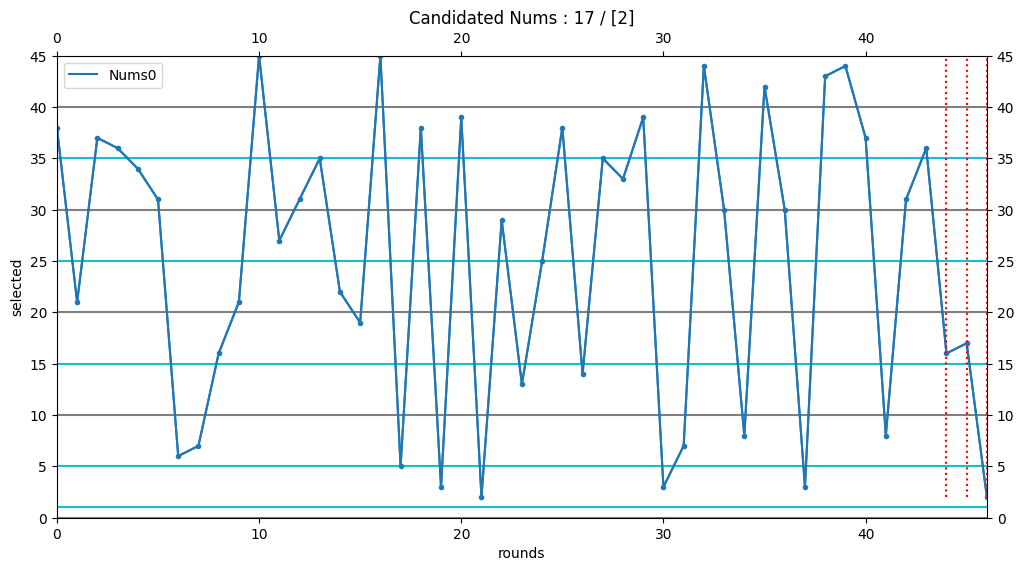

execute this code. [2025-08-18 18:48:57.652561]


In [36]:
row_nums = [1]
next_nums[row_nums[0]-1] = 2
draw_frequency(row_nums=row_nums, next_nums=[next_nums[row_nums[0]-1]])


[29, 26, 41, 17, 12, 33, 19, 37, 22, 15, 18, 29, 36, 9, 38, 10, 39, 7, 21, 28, 7, 12, 28, 2, 18, 29, 42, 40, 9, 26, 38, 3, 42, 35, 17, 8, 11, 43, 5, 18, 40, 14, 21, 4, 14, 6]
show_cols = [0]


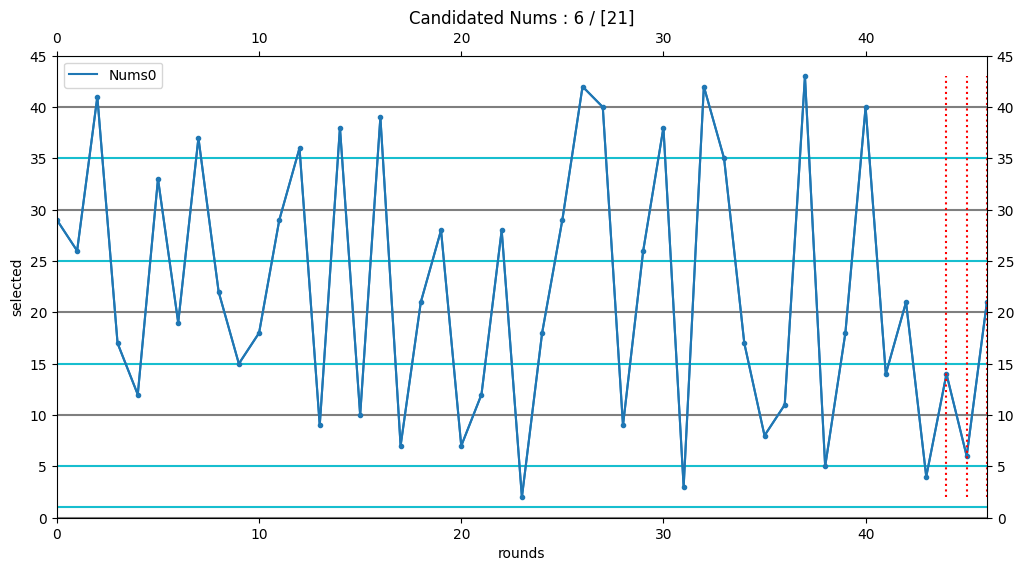

execute this code. [2025-08-18 18:48:58.612876]


In [37]:
row_nums = [2]
next_nums[row_nums[0]-1] = 21
draw_frequency(row_nums=row_nums, next_nums=[next_nums[row_nums[0]-1]])


[10, 35, 30, 27, 4, 2, 17, 11, 13, 8, 39, 9, 35, 44, 32, 37, 34, 20, 27, 39, 36, 34, 21, 33, 39, 45, 25, 8, 24, 24, 13, 12, 40, 20, 39, 4, 35, 7, 27, 16, 18, 20, 13, 15, 23, 32]
show_cols = [0]


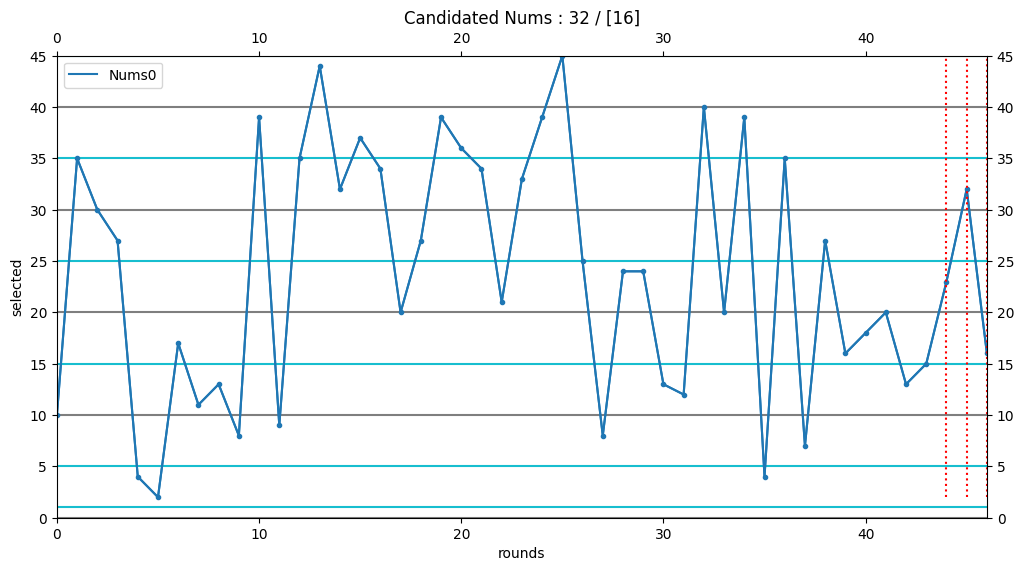

execute this code. [2025-08-18 18:48:59.904355]


In [38]:
row_nums = [3]
next_nums[row_nums[0]-1] = 16
draw_frequency(row_nums=row_nums, next_nums=[next_nums[row_nums[0]-1]])


[22, 12, 2, 16, 26, 11, 11, 26, 15, 32, 35, 3, 37, 13, 8, 27, 41, 26, 25, 9, 13, 24, 25, 16, 23, 7, 29, 31, 37, 12, 28, 6, 9, 1, 14, 3, 9, 15, 44, 24, 6, 41, 25, 23, 31, 28]
show_cols = [0]


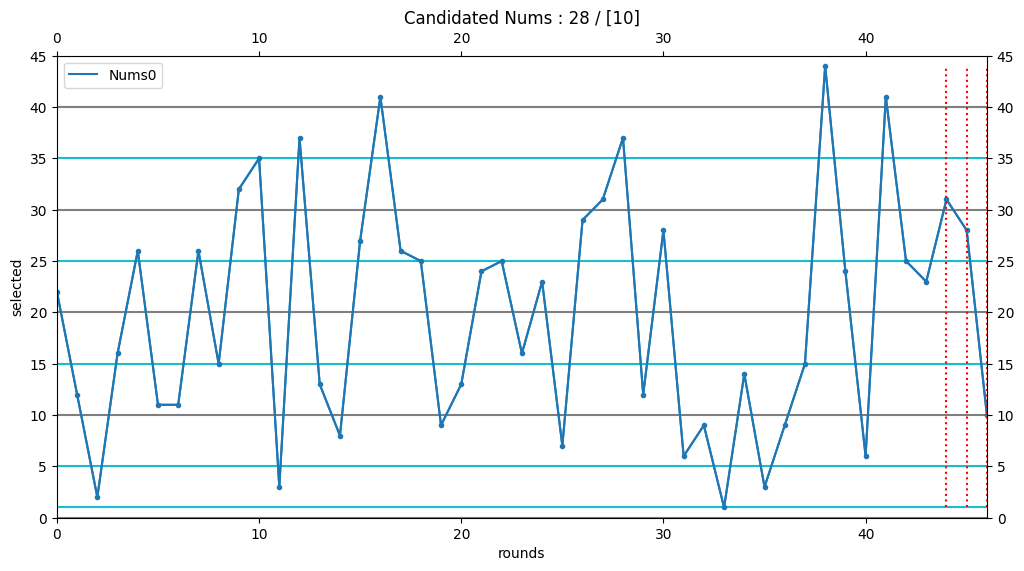

execute this code. [2025-08-18 18:49:00.363308]


In [39]:
row_nums = [4]
next_nums[row_nums[0]-1] = 10
draw_frequency(row_nums=row_nums, next_nums=[next_nums[row_nums[0]-1]])


[31, 7, 28, 10, 3, 44, 40, 24, 6, 36, 9, 15, 32, 1, 4, 38, 30, 25, 32, 38, 45, 20, 22, 15, 17, 6, 23, 39, 21, 42, 34, 17, 24, 18, 36, 6, 7, 19, 6, 40, 12, 10, 28, 17, 37, 29]
show_cols = [0]


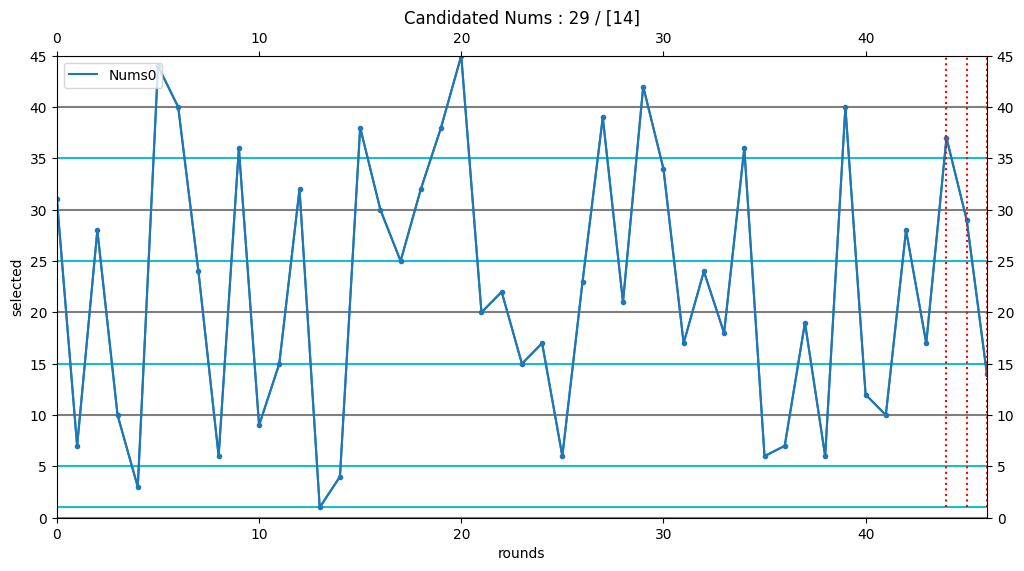

execute this code. [2025-08-18 18:49:00.902607]


In [40]:
row_nums = [5]
next_nums[row_nums[0]-1] = 14
draw_frequency(row_nums=row_nums, next_nums=[next_nums[row_nums[0]-1]])

[7, 11, 8, 28, 15, 37, 43, 27, 3, 19, 8, 2, 30, 10, 26, 16, 31, 12, 37, 27, 18, 42, 20, 43, 38, 27, 27, 23, 30, 5, 42, 11, 7, 5, 11, 32, 21, 16, 11, 3, 41, 33, 1, 27, 25, 22]
show_cols = [0]


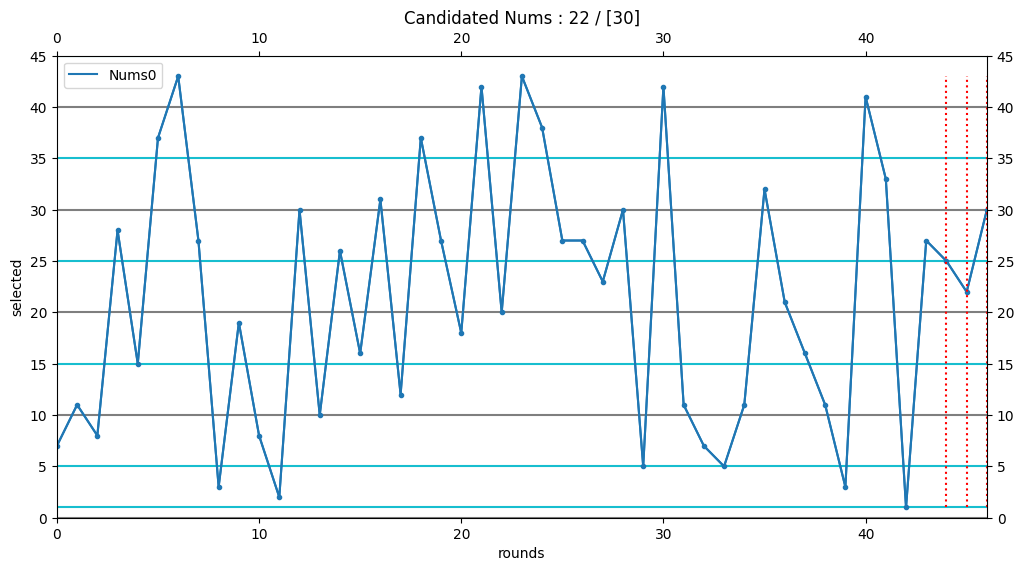

execute this code. [2025-08-18 18:49:01.529147]


In [41]:
row_nums = [6]
next_nums[row_nums[0]-1] = 30
draw_frequency(row_nums=row_nums, next_nums=[next_nums[row_nums[0]-1]])


[38, 21, 37, 36, 34, 31, 6, 7, 16, 21, 45, 27, 31, 35, 22, 19, 45, 5, 38, 3, 39, 2, 29, 13, 25, 38, 14, 35, 33, 39, 3, 7, 44, 30, 8, 42, 30, 3, 43, 44, 37, 8, 31, 36, 16, 17]
[29, 26, 41, 17, 12, 33, 19, 37, 22, 15, 18, 29, 36, 9, 38, 10, 39, 7, 21, 28, 7, 12, 28, 2, 18, 29, 42, 40, 9, 26, 38, 3, 42, 35, 17, 8, 11, 43, 5, 18, 40, 14, 21, 4, 14, 6]
[10, 35, 30, 27, 4, 2, 17, 11, 13, 8, 39, 9, 35, 44, 32, 37, 34, 20, 27, 39, 36, 34, 21, 33, 39, 45, 25, 8, 24, 24, 13, 12, 40, 20, 39, 4, 35, 7, 27, 16, 18, 20, 13, 15, 23, 32]
[22, 12, 2, 16, 26, 11, 11, 26, 15, 32, 35, 3, 37, 13, 8, 27, 41, 26, 25, 9, 13, 24, 25, 16, 23, 7, 29, 31, 37, 12, 28, 6, 9, 1, 14, 3, 9, 15, 44, 24, 6, 41, 25, 23, 31, 28]
[31, 7, 28, 10, 3, 44, 40, 24, 6, 36, 9, 15, 32, 1, 4, 38, 30, 25, 32, 38, 45, 20, 22, 15, 17, 6, 23, 39, 21, 42, 34, 17, 24, 18, 36, 6, 7, 19, 6, 40, 12, 10, 28, 17, 37, 29]
[7, 11, 8, 28, 15, 37, 43, 27, 3, 19, 8, 2, 30, 10, 26, 16, 31, 12, 37, 27, 18, 42, 20, 43, 38, 27, 27, 23, 30, 5, 42, 11, 

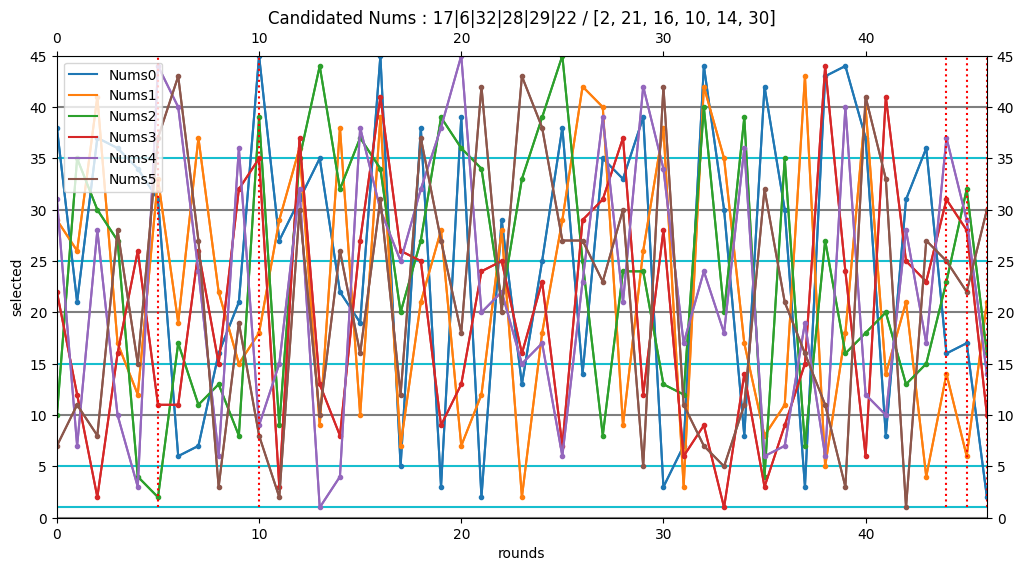

execute this code. [2025-08-18 18:49:03.296322]


In [42]:
row_nums = [1, 2, 3, 4, 5, 6]
draw_frequency(row_nums=row_nums, next_nums=next_nums)


In [43]:
next_nums.sort()
print(next_nums)

[2, 10, 14, 16, 21, 30]
